# Let's look closer at some regions that are showing big changes in coupling index based on changes between CESM1 and CESM2. 
<b> Author:</b> Meg Fowler <br>
<b> Date:</b> 2 Oct 2020 <br><br>
<b>Short description:</b> We have some interesting results from global maps of CI changes, but a better way to dig in might be to look at particularly interesting regions. What's going on in each? We can do that by picking out single points to assess vertical profiles, timeseries, etc., or also by drilling down maps into smaller regions to really understand some of the complexity there. <br><br>

In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data and do preliminary processing

### Read in files containing coupling index 
This part may need to be modified for future use, but the goal is that the rest of the script will *not* necessarily need to be.

In [2]:
# -----------------------------------------------------
#  Read in CESM2 coupling index files
# ----------------------------------------------------- 

# Define directory where files are saved 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

# Define file names 
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'   # CI(SM_10cm, LHFLX)
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'   # CI(SM_10cm, SHFLX)
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'     # CI(SHFLX, P_lcl)

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

# Save lat and lon into individual arrays (easier to reference later)
#  NOTE: it is assumed that all coupling indices are computed on a common grid. 
#        If that's not the case, then at the very least, lat/lon should be read in 
#        and saved for each different grid. 
lat = atmoLeg_CESM2.lat.values
lon = atmoLeg_CESM2.lon.values

print('Done reading in CESM2 coupling index files')


# -----------------------------------------------------
#  Read in CESM1 coupling index files
# ----------------------------------------------------- 

# Define data directory again 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

# Define file names 
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc'

# Read in coupling indices computed previously
atmoLeg_CESM1  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM1 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM1  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

print('Done reading in CESM1 coupling index files')


# -----------------------------------------------------
#  Read in CAM6+CLM4.5 coupling index files
# ----------------------------------------------------- 

# Define data directory again
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

# Define file name 
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously
atmoLeg_CLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

print('Done reading in CLM4.5 coupling index files')


Done reading in CESM2 coupling index files
Done reading in CESM1 coupling index files
Done reading in CLM4.5 coupling index files


### Some data processing on CI data: 
* Isolate JJA arrays 
* Mask out gridcells in AtmoLeg that fall over the ocean 
* Save the differences between simulations to arrays

In [3]:
# ------------------------------------------------------
#   Isolate seasonal CI into individual arrays based on model/season 
#   Note: Seasons are ordered as: [DJF, JJA, MAM, SON].
#         To confirm: print(terraLH_CESM2.season.values)
# ------------------------------------------------------

# CI (SM_10cm, LHFLX)
LHcoupl_JJA_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[0,:,:]))
LHcoupl_JJA_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[1,:,:]))
LHcoupl_DJF_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[0,:,:]))
LHcoupl_JJA_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[0,:,:]))


# CI (SM_10cm, SHFLX)
TerraLeg_JJA_cesm1 = np.squeeze(np.asarray(terraLeg_CESM1.soilM_10_SHFLX_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CESM2.mrsos_hfss_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CLM45.soilM_10_SHFLX_CI[1,:,:]))


# CI (SHFLX, Plcl)
AtmoLeg_JJA_cesm1  = np.squeeze(np.asarray(atmoLeg_CESM1.SHFLX_Plcl_CI[1,:,:]))
AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CESM2.hfss_Plcl_CI[1,:,:]))
AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CLM45.SHFLX_Plcl_CI[1,:,:]))



In [4]:
# ------------------------------------------------------
#  Define land mask to only consider land points 
# ------------------------------------------------------

# Based on TerraLeg, since that's only defined where there is soil moisture (and thus, land). 
lndMask = np.full([len(lat),len(lon)],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cesm1))] = 1 

# Mask out ocean gridpoints for AtmoLeg 
AtmoLeg_JJA_cesm1 = AtmoLeg_JJA_cesm1*lndMask
AtmoLeg_JJA_cesm2 = AtmoLeg_JJA_cesm2*lndMask
AtmoLeg_JJA_clm45 = AtmoLeg_JJA_clm45*lndMask


In [5]:
# ------------------------------------------------------
#  Save model differences to individual arrays as well 
# ------------------------------------------------------

# Differences in atmospheric leg of CI
atmoDiff_CESM2vCESM1 = AtmoLeg_JJA_cesm2 - AtmoLeg_JJA_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_JJA_cesm2 - AtmoLeg_JJA_clm45  # Impact of upgrading CAM 

# Difference in terrestrial leg of CI 
terraDiff_CESM2vCESM1 = TerraLeg_JJA_cesm2 - TerraLeg_JJA_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cesm2 - TerraLeg_JJA_clm45 # Impact of upgrading CAM 


### Read in files containing information on underlying variables: SM, SHF, and Plcl 

In [6]:
# ------------------------------------------------------
#   Read in files containing covariances 
# ------------------------------------------------------
dataDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
terraFile = dataDir+'Covars_SM-SHF.p'
atmoFile  = dataDir+'Covars_SHF-Plcl.p'

# Load data from pickle files 
covarCESM2_terra, covarCESM1_terra, covarCLM45_terra, covarCAM5_terra = pickle.load( open(terraFile, "rb") )
covarCESM2_atmo, covarCESM1_atmo, covarCLM45_atmo, covarCAM5_atmo     = pickle.load( open(atmoFile, "rb") )

# ------------------------------------------------------
#   Read in files containing raw variables of interest  
# ------------------------------------------------------
dataDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/'
CESM1file = dataDir+'CESM1_CI_variables-SHFLX_SM_Plcl.p'
CESM2file = dataDir+'CESM2_CI_variables-SHFLX_SM_Plcl.p'
CLM45file = dataDir+'CLM45_CI_variables-SHFLX_SM_Plcl.p'

# Load from pickle file 
SHflx_CESM2, soilM10_CESM2, Plcl_CESM2, SHFLX_CESM2_time = pickle.load( open(CESM2file,"rb")) # 1979-2006(Dec)
SHflx_CESM1, soilM10_CESM1, Plcl_CESM1, SHflx_CESM1_time = pickle.load( open(CESM1file,"rb")) # 1979-2006(Nov)
SHflx_CLM45, soilM10_CLM45, Plcl_CLM45, SHflx_CLM45_time = pickle.load( open(CLM45file,"rb")) # 1980-2005(Dec)

# ------------------------------------------------------
#   Read in files containing raw variables of interest, with daily climatology removed
#    Note that this is already reduced to JJA only
# ------------------------------------------------------
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
SHfile  = dataDir+'SHF-DailyClimoRemoved.p' 
SMfile  = dataDir+'SoilM-DailyClimoRemoved.p'

climoRemoved_SHFLX_CESM2, climoRemoved_SHFLX_CESM1, climoRemoved_SHFLX_CLM45 = pickle.load( open(SHfile,"rb"))
climoRemoved_SoilM_CESM2, climoRemoved_SoilM_CESM1, climoRemoved_SoilM_CLM45 = pickle.load( open(SMfile,"rb"))


In [34]:
# ------------------------------------------------------
#   Isolate JJA
# ------------------------------------------------------
# CESM2
dates_CESM2   = pd.DatetimeIndex(SHFLX_CESM2_time.values)
iJJA_CESM2    = np.where((dates_CESM2.month>=6) & (dates_CESM2.month<=8) &
                        (dates_CESM2.year>=1980) & (dates_CESM2.year<=2005))[0]
SHflx_JJA_CESM2   = SHflx_CESM2[iJJA_CESM2,:,:]
soilM10_JJA_CESM2 = soilM10_CESM2[iJJA_CESM2,:,:]
Plcl_JJA_CESM2    = Plcl_CESM2[iJJA_CESM2,:,:]
dates_CESM2       = dates_CESM2[iJJA_CESM2]

# CESM1
dates_CESM1   = pd.DatetimeIndex(SHflx_CESM1_time.values)
iJJA_CESM1    = np.where((dates_CESM1.month>=6) & (dates_CESM1.month<=8) &
                        (dates_CESM1.year>=1980) & (dates_CESM1.year<=2005))[0]
SHflx_JJA_CESM1   = SHflx_CESM1[iJJA_CESM1,:,:]
soilM10_JJA_CESM1 = soilM10_CESM1[iJJA_CESM1,:,:]
Plcl_JJA_CESM1    = Plcl_CESM1[iJJA_CESM1,:,:]
dates_CESM1       = dates_CESM1[iJJA_CESM1]

# CLM4.5 
dates_CLM45       = pd.DatetimeIndex(SHflx_CLM45_time.values)
iJJA_CLM45        = np.where((dates_CLM45.month>=6) & (dates_CLM45.month<=8))[0]
SHflx_JJA_CLM45   = SHflx_CLM45[iJJA_CLM45,:,:]
soilM10_JJA_CLM45 = soilM10_CLM45[iJJA_CLM45,:,:]
Plcl_JJA_CLM45    = Plcl_CLM45[iJJA_CLM45,:,:]
dates_CLM45       = dates_CLM45[iJJA_CLM45]


Just to note, the time periods aren't *entirely* consistent between each model version (though very similar). For the fully coupled CESM simulations, data for the coupling index and for the underlying variables runs from Jan 1979 through Nov/Dec 2006. For the CLM4.5 simulation, data is from Jan 1980 through Dec 2005. So two years less data go into computing mean behavior for CLM4.5. <br> <br>
I personally doubt this has a huge impact - sensitivity tests on 5-year selections of data showed consistent coupling index results, so I don't think adding/removing a year or two out of a 25-30 year record is critical. <br><br>

## To start simply, let's make zonal mean plots of underlying variable changes 
These can then be compared with the zonal mean plots of CI made previously

In [23]:
# ------------------------------------------------------
#  Compute standard deviation of SHFLX and SoilM 
#    (daily climatology has been removed first)
# ------------------------------------------------------
SM_JJAstd_CESM2  = np.nanstd(climoRemoved_SoilM_CESM2, axis=0)
SM_JJAstd_CESM1  = np.nanstd(climoRemoved_SoilM_CESM1, axis=0)
SM_JJAstd_CLM45  = np.nanstd(climoRemoved_SoilM_CLM45, axis=0)

SH_JJAstd_CESM2  = np.nanstd(climoRemoved_SHFLX_CESM2, axis=0)
SH_JJAstd_CESM1  = np.nanstd(climoRemoved_SHFLX_CESM1, axis=0)
SH_JJAstd_CLM45  = np.nanstd(climoRemoved_SHFLX_CLM45, axis=0)


/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [24]:
# ------------------------------------------------------
#   Compute zonal means of variables 
#     First, average over JJA. Then average over longitude
# ------------------------------------------------------

# ----- SHFLX -----
shflx_CESM2_JJA = np.nanmean(SHflx_JJA_CESM2,axis=0)  # Average over JJA 
shflx_CESM1_JJA = np.nanmean(SHflx_JJA_CESM1,axis=0)
shflx_CLM45_JJA = np.nanmean(SHflx_JJA_CLM45,axis=0)

lonMean_shflx_CESM2 = np.nanmean(shflx_CESM2_JJA*lndMask,axis=1) # Average over longitude 
lonMean_shflx_CESM1 = np.nanmean(shflx_CESM1_JJA*lndMask,axis=1)
lonMean_shflx_CLM45 = np.nanmean(shflx_CLM45_JJA*lndMask,axis=1)
# -----------------

# ----- SoilM_10CM -----
soilm_CESM2_JJA = np.nanmean(soilM10_JJA_CESM2,axis=0)  # Average over JJA 
soilm_CESM1_JJA = np.nanmean(soilM10_JJA_CESM1,axis=0)
soilm_CLM45_JJA = np.nanmean(soilM10_JJA_CLM45,axis=0)

lonMean_soilm_CESM2 = np.nanmean(soilm_CESM2_JJA*lndMask,axis=1) # Average over longitude 
lonMean_soilm_CESM1 = np.nanmean(soilm_CESM1_JJA*lndMask,axis=1)
lonMean_soilm_CLM45 = np.nanmean(soilm_CLM45_JJA*lndMask,axis=1)
# ---------------------

# ----- Plcl -----
plcl_CESM2_JJA = np.nanmean(Plcl_JJA_CESM2,axis=0)  # Average over JJA 
plcl_CESM1_JJA = np.nanmean(Plcl_JJA_CESM1,axis=0)
plcl_CLM45_JJA = np.nanmean(Plcl_JJA_CLM45,axis=0)

lonMean_plcl_CESM2 = np.nanmean(plcl_CESM2_JJA*lndMask,axis=1) # Average over longitude 
lonMean_plcl_CESM1 = np.nanmean(plcl_CESM1_JJA*lndMask,axis=1)
lonMean_plcl_CLM45 = np.nanmean(plcl_CLM45_JJA*lndMask,axis=1)
# -----------------

# ----- Covar(SM, SHFLX) -----
covarTerra_CESM2_JJA = covarCESM2_terra[1,:,:]  # Select JJA season 
covarTerra_CESM1_JJA = covarCESM1_terra[1,:,:]
covarTerra_CLM45_JJA = covarCLM45_terra[1,:,:]

lonMean_covarTerra_CESM2 = np.nanmean(covarTerra_CESM2_JJA*lndMask,axis=1) # Average over longitude 
lonMean_covarTerra_CESM1 = np.nanmean(covarTerra_CESM1_JJA*lndMask,axis=1)
lonMean_covarTerra_CLM45 = np.nanmean(covarTerra_CLM45_JJA*lndMask,axis=1)
# -----------------------------

# ----- Covar(SHFLX, Plcl) -----
covarAtmo_CESM2_JJA = covarCESM2_atmo[1,:,:]    # Select JJA season 
covarAtmo_CESM1_JJA = covarCESM1_atmo[1,:,:]
covarAtmo_CLM45_JJA = covarCLM45_atmo[1,:,:]

lonMean_covarAtmo_CESM2 = np.nanmean(covarAtmo_CESM2_JJA*lndMask,axis=1) # Average over longitude 
lonMean_covarAtmo_CESM1 = np.nanmean(covarAtmo_CESM1_JJA*lndMask,axis=1)
lonMean_covarAtmo_CLM45 = np.nanmean(covarAtmo_CLM45_JJA*lndMask,axis=1)
# -----------------------------

# ----- std(SHFLX) -----
lonMean_StdShflx_CESM2 = np.nanmean(SH_JJAstd_CESM2*lndMask,axis=1) # Average over longitude 
lonMean_StdShflx_CESM1 = np.nanmean(SH_JJAstd_CESM1*lndMask,axis=1)
lonMean_StdShflx_CLM45 = np.nanmean(SH_JJAstd_CLM45*lndMask,axis=1)
# ----------------------

# ----- std(SM) -----
lonMean_StdSoilm_CESM2 = np.nanmean(SM_JJAstd_CESM2*lndMask,axis=1) # Average over longitude 
lonMean_StdSoilm_CESM1 = np.nanmean(SM_JJAstd_CESM1*lndMask,axis=1)
lonMean_StdSoilm_CLM45 = np.nanmean(SM_JJAstd_CLM45*lndMask,axis=1)
# ----------------------


<ipython-input-24-b5d0f2ba9ce2>:11: RuntimeWarning: Mean of empty slice
  lonMean_shflx_CESM2 = np.nanmean(shflx_CESM2_JJA*lndMask,axis=1) # Average over longitude
<ipython-input-24-b5d0f2ba9ce2>:12: RuntimeWarning: Mean of empty slice
  lonMean_shflx_CESM1 = np.nanmean(shflx_CESM1_JJA*lndMask,axis=1)
<ipython-input-24-b5d0f2ba9ce2>:13: RuntimeWarning: Mean of empty slice
  lonMean_shflx_CLM45 = np.nanmean(shflx_CLM45_JJA*lndMask,axis=1)
<ipython-input-24-b5d0f2ba9ce2>:17: RuntimeWarning: Mean of empty slice
  soilm_CESM2_JJA = np.nanmean(soilM10_JJA_CESM2,axis=0)  # Average over JJA
<ipython-input-24-b5d0f2ba9ce2>:18: RuntimeWarning: Mean of empty slice
  soilm_CESM1_JJA = np.nanmean(soilM10_JJA_CESM1,axis=0)
<ipython-input-24-b5d0f2ba9ce2>:19: RuntimeWarning: Mean of empty slice
  soilm_CLM45_JJA = np.nanmean(soilM10_JJA_CLM45,axis=0)
<ipython-input-24-b5d0f2ba9ce2>:21: RuntimeWarning: Mean of empty slice
  lonMean_soilm_CESM2 = np.nanmean(soilm_CESM2_JJA*lndMask,axis=1) # Average ov

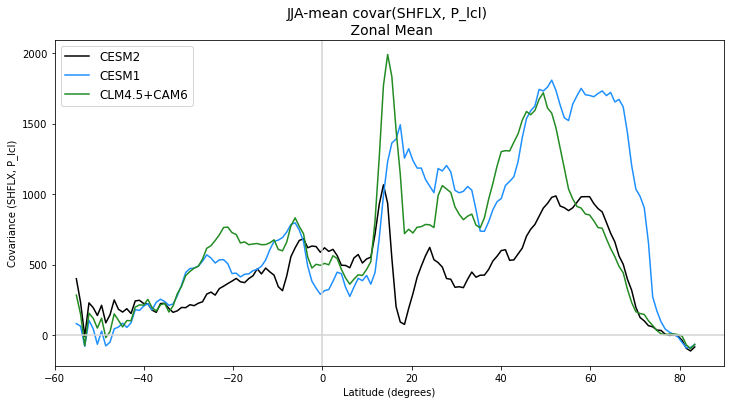

In [28]:
# ------------------------------------------------------
#  Now plot zonal mean of selected variable. 
#  Valid choices for 'varPlot' are: 'shflx', 'soilM_10',
#     'Plcl', 'covar_terra', 'covar_atmo', 'shflx_std', 
#     'soilM_10_std'
# ------------------------------------------------------

# DEFINE VARIABLE HERE 
varPlot = 'covar_atmo'

# ------ Define data arrays to be plotted ------
if varPlot == 'shflx':
    lonMean_CESM2 = lonMean_shflx_CESM2
    lonMean_CESM1 = lonMean_shflx_CESM1
    lonMean_CLM45 = lonMean_shflx_CLM45
    # A few plot options to specify 
    pltTitle = 'JJA-mean SHFLX \n Zonal Mean'
    yTitle   = 'SHFLX [W/m2]' 
elif varPlot == 'soilM_10':
    lonMean_CESM2 = lonMean_soilm_CESM2
    lonMean_CESM1 = lonMean_soilm_CESM1
    lonMean_CLM45 = lonMean_soilm_CLM45
    # A few plot options
    pltTitle = 'JJA-mean soilM_10cm \n Zonal Mean'
    yTitle   = '10cm Soil Moisture [kg/m2]'
elif varPlot == 'Plcl':
    lonMean_CESM2 = lonMean_plcl_CESM2
    lonMean_CESM1 = lonMean_plcl_CESM1
    lonMean_CLM45 = lonMean_plcl_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean P_lcl \n Zonal Mean'
    yTitle   = 'Pressure level of the LCL [hPa above the surface]'
elif varPlot == 'covar_terra':
    lonMean_CESM2 = lonMean_covarTerra_CESM2
    lonMean_CESM1 = lonMean_covarTerra_CESM1
    lonMean_CLM45 = lonMean_covarTerra_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean covar(SM, SHFLX) \n Zonal Mean'
    yTitle   = 'Covariance (soilM_10cm, SHFLX)'
elif varPlot == 'covar_atmo':
    lonMean_CESM2 = lonMean_covarAtmo_CESM2
    lonMean_CESM1 = lonMean_covarAtmo_CESM1
    lonMean_CLM45 = lonMean_covarAtmo_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean covar(SHFLX, P_lcl) \n Zonal Mean'
    yTitle   = 'Covariance (SHFLX, P_lcl)'
elif varPlot == 'shflx_std':
    lonMean_CESM2 = lonMean_StdShflx_CESM2
    lonMean_CESM1 = lonMean_StdShflx_CESM1
    lonMean_CLM45 = lonMean_StdShflx_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean std(SHFLX) \n Zonal Mean'
    yTitle   = 'Standard deviation of SHFLX (daily climo removed)'
elif varPlot == 'soilM_10_std':
    lonMean_CESM2 = lonMean_StdSoilm_CESM2
    lonMean_CESM1 = lonMean_StdSoilm_CESM1
    lonMean_CLM45 = lonMean_StdSoilm_CLM45
    # A few plot options 
    pltTitle = 'JJA-mean std(soilM_10cm) \n Zonal Mean'
    yTitle   = 'Standard deviation of soilM (daily climo removed)'
else:
    print('***** Please select available zonal mean variable to plot ******')

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,lonMean_CESM2,'k')
ax1.plot(lat,lonMean_CESM1,'dodgerblue')
ax1.plot(lat,lonMean_CLM45,'forestgreen')

#ax1.legend(['CESM2','CESM1','CLM4.5+CAM6','CLM5+CAM5'])
ax1.legend(['CESM2','CESM1','CLM4.5+CAM6'], fontsize=12)
ax1.set_xlabel('Latitude (degrees)')
ax1.set_ylabel(yTitle)
ax1.set_title(pltTitle, fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')

## Define interesting regions 
A few potential locations of interest have already been identified in analysis to isolate IOP points. So let's start there with what we have. 


In [31]:
# ------------------------------------------------------
#   Identify lat/lon indices of interesting gridcells 
# ------------------------------------------------------

# Linsk, Russia
ilat_Linsk = np.where( (lat>=60.2) & (lat<=61.2))[0]
ilon_Linsk = np.where( (lon>=114.5) & (lon<=115.5))[0]

# Northern Alaska 
ilat_AK = np.where( (lat>=68.5) & (lat<=69.5))[0]
lonSel_AK = (-150.8514 + 360) % 360                 # Convert longitude of point into 0-360 range 
ilon_AK = np.where( (lon>=(lonSel_AK-0.59)) & (lon<=(lonSel_AK+0.59)) )

# Santa Fe, NM 
ilat_SantaFe = np.where( (lat>=35.1) & (lat<=36.1))[0]
lonSel_SF = (-105.9378 + 360) % 360                 # Convert longitude of point into 0-360 range 
ilon_SantaFe = np.where( (lon>=(lonSel_SF-0.59)) & (lon<=(lonSel_SF+0.59)) )

# Jalna, India
ilat_Jalna = np.where( (lat>=19.33) & (lat<=20.33))[0]
ilon_Jalna = np.where( (lon>=75.3) & (lon<=76.3))[0]

# Print out lat and lon values (used for getting profiles with ncrcat)
#  As in: ncrcat -v T,Q,U,V,CLOUD -d lon,208.75 -d lat,69.26701571 in_file[s].nc out_file.nc
print('Location     Lon     Lat')
print('Linsk:    ', lon[ilon_Linsk],  lat[ilat_Linsk])
print('Alaska:   ', lon[ilon_AK],     lat[ilat_AK])
print('Santa Fe: ', lon[ilon_SantaFe],lat[ilat_SantaFe])
print('Jalna:    ', lon[ilon_Jalna],  lat[ilat_Jalna])


Location     Lon     Lat
Linsk:     [115.] [60.78534031]
Alaska:    [208.75] [69.26701571]
Santa Fe:  [253.75] [35.34031414]
Jalna:     [76.25] [20.2617801]


### Isolate those points in underlying data as well

In [30]:
np.shape(soilM10_CESM2)

(10220, 192, 288)

In [36]:
# ------------------------------------------------------
#  Grab timeseries of soilM10, SHFLX at Linsk
# ------------------------------------------------------

Linsk_soilM10_CESM2 = soilM10_JJA_CESM2[:, ilat_Linsk, ilon_Linsk]
Linsk_soilM10_CESM1 = soilM10_JJA_CESM1[:, ilat_Linsk, ilon_Linsk]
Linsk_soilM10_CLM45 = soilM10_JJA_CLM45[:, ilat_Linsk, ilon_Linsk]


(723332.0, 723424.0)

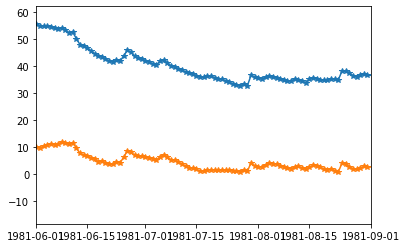

In [47]:
plt.plot(dates_CESM2, Linsk_soilM10_CESM2,'*-')
plt.plot(dates_CESM2, climoRemoved_SoilM_CESM2[:, ilat_Linsk, ilon_Linsk],'*-')
plt.xlim([datetime.date(1981,6,1), datetime.date(1981,9,1)])

### Read in vertical profiles of data

In [53]:
# ------------------------------------------------------
#   Read in vertical profiles of key variables at these four 
#   locations - data concat'ed on Casper previously. 
# ------------------------------------------------------
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/VerticalProfiles/'


# ----- Read in CESM2 data ---- 
#  In this run, variables are saved in individual files 

FileLinsk_CL       = dataDir+'CESM2/'+'cl_CFday_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullLinskProfile.nc'
FileNorthAlaska_CL = dataDir+'CESM2/'+'cl_CFday_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullNorthAlaskaProfile.nc'
FileSantaFe_CL     = dataDir+'CESM2/'+'cl_CFday_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullSantaFeProfile.nc'
FileJalna_CL       = dataDir+'CESM2/'+'cl_CFday_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullJalnaProfile.nc'

FileLinsk_HUS       = dataDir+'CESM2/'+'hus_day_CESM2_amip_r10i1p1f1_gn_19900101-19991231_FullLinskProfile.nc'
FileNorthAlaska_HUS = dataDir+'CESM2/'+'hus_day_CESM2_amip_r10i1p1f1_gn_19900101-19991231_FullNorthAlaskakProfile.nc'
FileSantaFe_HUS     = dataDir+'CESM2/'+'hus_day_CESM2_amip_r10i1p1f1_gn_19900101-19991231_FullSantaFeProfile.nc'
FileJalna_HUS       = dataDir+'CESM2/'+'hus_day_CESM2_amip_r10i1p1f1_gn_19900101-19991231_FullJalnaProfile.nc'

FileLinsk_TA       = dataDir+'CESM2/'+'ta_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullLinskProfile.nc'
FileNorthAlaska_TA = dataDir+'CESM2/'+'ta_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullNorthAlaskaProfile.nc'
FileSantaFe_TA     = dataDir+'CESM2/'+'ta_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullSantaFeProfile.nc'
FileJalna_TA       = dataDir+'CESM2/'+'ta_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullJalnaProfile.nc'

FileLinsk_UA       = dataDir+'CESM2/'+'ua_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullLinksProfile.nc'
FileNorthAlaska_UA = dataDir+'CESM2/'+'ua_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullNorthAlaskaProfile.nc'
FileSantaFe_UA     = dataDir+'CESM2/'+'ua_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullSantaFeProfile.nc'
FileJalna_UA       = dataDir+'CESM2/'+'ua_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullJalnaProfile.nc'

FileLinsk_VA       = dataDir+'CESM2/'+'va_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullLinskProfile.nc'
FileNorthAlaska_VA = dataDir+'CESM2/'+'va_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullNorthAlaskaProfile.nc'
FileSantaFe_VA     = dataDir+'CESM2/'+'va_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullSantaFeProfile.nc'
FileJalna_VA       = dataDir+'CESM2/'+'va_day_CESM2_amip_r10i1p1f1_gn_19800101-20091231_FullJalnaProfile.nc'

LinskCL   = xr.open_dataset(FileLinsk_CL,       decode_times=True)
AlaskaCL  = xr.open_dataset(FileNorthAlaska_CL, decode_times=True)
SantaFeCL = xr.open_dataset(FileSantaFe_CL,     decode_times=True)
JalnaCL   = xr.open_dataset(FileJalna_CL,       decode_times=True)

LinskHUS   = xr.open_dataset(FileLinsk_HUS,       decode_times=True)
AlaskaHUS  = xr.open_dataset(FileNorthAlaska_HUS, decode_times=True) 
SatnaFeHUS = xr.open_dataset(FileSantaFe_HUS,     decode_times=True)
JalnaHUS   = xr.open_dataset(FileJalna_HUS,       decode_times=True)

LinskTA   = xr.open_dataset(FileLinsk_TA,       decode_times=True)
AlaskaTA  = xr.open_dataset(FileNorthAlaska_TA, decode_times=True)
SantaFeTA = xr.open_dataset(FileSantaFe_TA,     decode_times=True)
JalnaTA   = xr.open_dataset(FileJalna_TA,       decode_times=True)

LinskUA   = xr.open_dataset(FileLinsk_UA,       decode_times=True)
AlaskaUA  = xr.open_dataset(FileNorthAlaska_UA, decode_times=True)
SantaFeUA = xr.open_dataset(FileSantaFe_UA,     decode_times=True)
JalnaUA   = xr.open_dataset(FileJalna_UA,       decode_times=True)

LinskVA   = xr.open_dataset(FileLinsk_VA,       decode_times=True)
AlaskaVA  = xr.open_dataset(FileNorthAlaska_VA, decode_times=True)
SantaFeVA = xr.open_dataset(FileSantaFe_VA,     decode_times=True)
JalnaVA   = xr.open_dataset(FileJalna_VA,       decode_times=True)

# Get time in usable format
LinskCL['time'] = LinskCL.indexes['time'].to_datetimeindex()
LinskHUS['time'] = LinskHUS.indexes['time'].to_datetimeindex()
# -----------------------------


# ----- Read in CESM1 data ---- 
FileLinsk_CESM1       = dataDir+'CESM1/'+'cam5.1_amip_1d_002.cam2.h1.1980-2005_FullLinskProfiles.nc'
FileNorthAlaska_CESM1 = dataDir+'CESM1/'+'cam5.1_amip_1d_002.cam2.h1.1980-2005_FullNorthAlaskaProfiles.nc'
FileSantaFe_CESM1     = dataDir+'CESM1/'+'cam5.1_amip_1d_002.cam2.h1.1980-2005_FullSantaFeProfiles.nc'
FileJalna_CESM1       = dataDir+'CESM1/'+'cam5.1_amip_1d_002.cam2.h1.1980-2005_FullJalnaProfiles.nc'

Linsk_CESM1   = xr.open_dataset(FileLinsk_CESM1, decode_times=True)
Alaska_CESM1  = xr.open_dataset(FileNorthAlaska_CESM1, decode_times=True)
SantaFe_CESM1 = xr.open_dataset(FileSantaFe_CESM1, decode_times=True)
Jalna_CESM1   = xr.open_dataset(FileJalna_CESM1, decode_times=True)

# Get time in usable format 
Linsk_CESM1['time'] = Linsk_CESM1.indexes['time'].to_datetimeindex()
# -----------------------------


# ----- Read in CLM4.5 data ---- 
FileLinsk_CLM45       = dataDir+'CLM45/'+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-2005_FullLinskProfiles.nc'
FileNorthAlaska_CLM45 = dataDir+'CLM45/'+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-2005_FullNorthAlaskaProfiles.nc'
FileSantaFe_CLM45     = dataDir+'CLM45/'+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-2005_FullSantaFeProfiles.nc'
FileJalna_CLM45       = dataDir+'CLM45/'+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-2005_FullJalnaProfiles.nc'

Linsk_CLM45   = xr.open_dataset(FileLinsk_CLM45,       decode_times=True)
Alaska_CLM45  = xr.open_dataset(FileNorthAlaska_CLM45, decode_times=True) 
SantaFe_CLM45 = xr.open_dataset(FileSantaFe_CLM45,     decode_times=True)
Jalna_CLM45   = xr.open_dataset(FileJalna_CLM45,       decode_times=True)

# Get time in usable format
Linsk_CLM45['time'] = Linsk_CLM45.indexes['time'].to_datetimeindex()
# -----------------------------


/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'cl' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'hus' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'ua' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: Serializat

In [71]:
# ------------------------------------------------------
#   Limit by time (we only have HUS for 1990s in CESM2 sim)
# ------------------------------------------------------

# ---------------------------------
# Step 1: Define pandas date arrays 
# ---------------------------------
dates_CESM2 = pd.DatetimeIndex(LinskCL.time.values)
dates_1990s = pd.DatetimeIndex(LinskHUS.time.values)
dates_CESM1 = pd.DatetimeIndex(Linsk_CESM1.time.values)
dates_CLM45 = pd.DatetimeIndex(Linsk_CLM45.time.values)

# ---------------------------------
# Step 2: Limit each array to 1990s 
# ---------------------------------
iSel_CESM2  = np.where((dates_CESM2>=min(dates_1990s)) & (dates_CESM2<=max(dates_1990s)))[0]
dates_CESM2 = dates_CESM2[iSel_CESM2]

LinskCL_sel    = LinskCL.isel(time=iSel_CESM2)
AlaskaCL_sel   = AlaskaCL.isel(time=iSel_CESM2)
SantaFeCL_sel  = SantaFeCL.isel(time=iSel_CESM2)
JalnaCL_sel    = JalnaCL.isel(time=iSel_CESM2)

LinskTA_sel    = LinskTA.isel(time=iSel_CESM2)
AlaskaTA_sel   = AlaskaTA.isel(time=iSel_CESM2)
SantaFeTA_sel  = SantaFeTA.isel(time=iSel_CESM2)
JalnaTA_sel    = JalnaTA.isel(time=iSel_CESM2)

LinskUA_sel    = LinskUA.isel(time=iSel_CESM2)
AlaskaUA_sel   = AlaskaUA.isel(time=iSel_CESM2)
SantaFeUA_sel  = SantaFeUA.isel(time=iSel_CESM2)
JalnaUA_sel    = JalnaUA.isel(time=iSel_CESM2)

LinskVA_sel    = LinskVA.isel(time=iSel_CESM2)
AlaskaVA_sel   = AlaskaVA.isel(time=iSel_CESM2)
SantaFeVA_sel  = SantaFeVA.isel(time=iSel_CESM2)
JalnaVA_sel    = JalnaVA.isel(time=iSel_CESM2)
# -----
iSel_CESM1 = np.where((dates_CESM1>=min(dates_1990s)) & (dates_CESM1<=max(dates_1990s)))[0] 
dates_CESM1       = dates_CESM1[iSel_CESM1]
Linsk_CESM1_sel   = Linsk_CESM1.isel(time=iSel_CESM1)
Alaska_CESM1_sel  = Alaska_CESM1.isel(time=iSel_CESM1)
SantaFe_CESM1_sel = SantaFe_CESM1.isel(time=iSel_CESM1)
Jalna_CESM1_sel   = Jalna_CESM1.isel(time=iSel_CESM1)
# -----
iSel_CLM45 = np.where((dates_CLM45>=min(dates_1990s)) & (dates_CLM45<=max(dates_1990s)))[0]
dates_CLM45       = dates_CLM45[iSel_CLM45]
Linsk_CLM45_sel   = Linsk_CLM45.isel(time=iSel_CLM45)
Alaska_CLM45_sel  = Alaska_CLM45.isel(time=iSel_CLM45)
SantaFe_CLM45_sel = SantaFe_CLM45.isel(time=iSel_CLM45)
Jalna_CLM45_sel   = Jalna_CLM45.isel(time=iSel_CLM45)

# --------------------
# Step 3: Limit to JJA 
# ---------------------
iJJA_CESM2 = np.where((dates_CESM2.month>=6) & (dates_CESM2.month<=8))[0]
dates_CESM2 = dates_CESM2[iJJA_CESM2]

LinskCL_JJA = LinskCL_sel.isel(time=iJJA_CESM2)
AlaskaCL_JJA   = AlaskaCL_sel.isel(time=iJJA_CESM2)
SantaFeCL_JJA  = SantaFeCL_sel.isel(time=iJJA_CESM2)
JalnaCL_JJA    = JalnaCL_sel.isel(time=iJJA_CESM2)

LinskTA_JJA    = LinskTA_sel.isel(time=iJJA_CESM2)
AlaskaTA_JJA   = AlaskaTA_sel.isel(time=iJJA_CESM2)
SantaFeTA_JJA  = SantaFeTA_sel.isel(time=iJJA_CESM2)
JalnaTA_JJA    = JalnaTA_sel.isel(time=iJJA_CESM2)

LinskUA_JJA    = LinskUA_sel.isel(time=iJJA_CESM2)
AlaskaUA_JJA   = AlaskaUA_sel.isel(time=iJJA_CESM2)
SantaFeUA_JJA  = SantaFeUA_sel.isel(time=iJJA_CESM2)
JalnaUA_JJA    = JalnaUA_sel.isel(time=iJJA_CESM2)

LinskVA_JJA    = LinskVA_sel.isel(time=iJJA_CESM2)
AlaskaVA_JJA   = AlaskaVA_sel.isel(time=iJJA_CESM2)
SantaFeVA_JJA  = SantaFeVA_sel.isel(time=iJJA_CESM2)
JalnaVA_JJA    = JalnaVA_sel.isel(time=iJJA_CESM2)

# ----
iJJA_CESM1  = np.where((dates_CESM1.month>=6) & (dates_CESM1.month<=8))[0]
dates_CESM1 = dates_CESM1[iJJA_CESM1]       
Linsk_CESM1_JJA   = Linsk_CESM1_sel.isel(time=iJJA_CESM1)
Alaska_CESM1_JJA  = Alaska_CESM1_sel.isel(time=iJJA_CESM1)
SantaFe_CESM1_JJA = SantaFe_CESM1_sel.isel(time=iJJA_CESM1)
Jalna_CESM1_JJA   = Jalna_CESM1_sel.isel(time=iJJA_CESM1)
# -----
iJJA_CLM45  = np.where((dates_CLM45.month>=6) & (dates_CLM45.month<=8))[0]
dates_CLM45 = dates_CLM45[iJJA_CLM45]
Linsk_CLM45_JJA   = Linsk_CLM45_sel.isel(time=iJJA_CLM45)
Alaska_CLM45_JJA  = Alaska_CLM45_sel.isel(time=iJJA_CLM45)
SantaFe_CLM45_JJA = SantaFe_CLM45_sel.isel(time=iJJA_CLM45)
Jalna_CLM45_JJA   = Jalna_CLM45_sel.isel(time=iJJA_CLM45)

### Make vertical profiles 

In [ ]:
# ----------------------------------------
# Prep for plotting by selection location and time option 
#   Valid location options: 'Linsk', 'NorthAK','SantaFe','Jalna'
#   Valid time options: An integer, from 0-920 (inclusive); or 'mean_june','mean_july','mean_august' 
# ----------------------------------------


# ---- Input location and time choice ----
locChoice = 'Linsk'
dayChoice = 75
# ---------------------------------------



# ------ Define data arrays to be plotted ------
# Define location 
if locChoice == 'Linsk':
    CESM2_cloud = np.flip(np.squeeze(LinskCL_JJA.cl.values[iDay,:]))
    CESM1_cloud = np.squeeze(Linsk_CESM1_JJA.CLOUD.values[iDay,:])*100
    CLM45_cloud = np.squeeze(Linsk_CLM45_JJA.CLOUD.values[iDay,:])*100
    
    CESM2_Q     = 
    CESM1_Q     = 
    CLM45_Q     = 
    
    CESM2_T     = 
    CESM1_T     = 
    CLM45_T     = 
    
elif locChoice == 'NorthAK':
    
    
elif locChoice == 'SantaFe':
    
    
elif locChoice == 'Jalna': 
    
else: 
    print('**** Need to choose a valid value for location ****')
    
# Define time period or day 
if dayChoice=='mean_june':
    
elif dayChoice=='mean_july':
    
elif dayChoice=='mean_august':
    
elif ((dayChoice>=0) & (dayChoice<=len(dates_CESM2))):
    
else: 
    print('**** Need to choose a valid time option ****')





In [84]:
LinskTA_JJA.plev

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
Attributes:
    axis:           Z
    positive:       down
    requested:      100000. 85000. 70000. 50000. 25000. 10000. 5000. 1000.
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          Pa

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

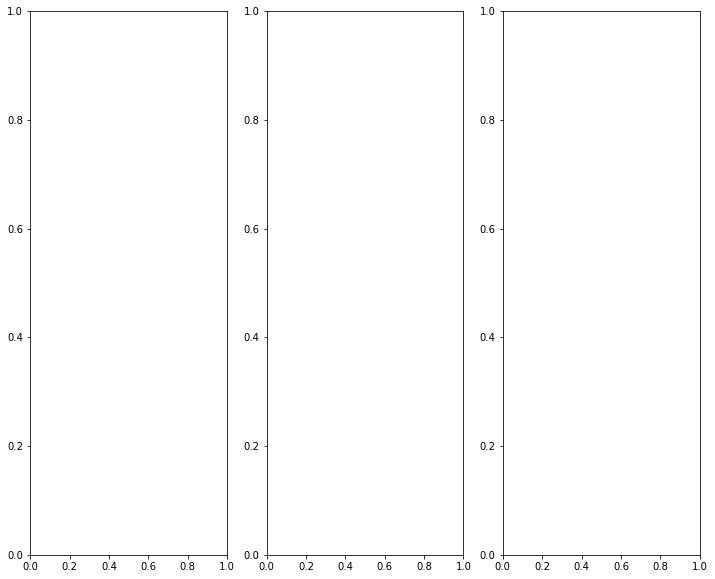

In [78]:
# --------------------------------------
#  Vertical profiles of T, Q, CLOUD % 
# --------------------------------------


# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(12,10))
#Adjust space between subplots 
# fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

iDay = 50 


axs[0].plot(np.flip(np.squeeze(LinskCL_JJA.cl.values[iDay,:])),np.flip(LinskCL_JJA.lev.values*1000),'k*-')
axs[0].plot(np.squeeze(Linsk_CESM1_JJA.CLOUD.values[iDay,:])*100, Linsk_CESM1_JJA.lev.values,'b*-')
axs[0].plot(np.squeeze(Linsk_CLM45_JJA.CLOUD.values[iDay,:])*100, Linsk_CLM45_JJA.lev.values,'g*-')

plt.gca().invert_yaxis()
axs[0].legend(['CESM2','CESM1','CLM4.5+CAM6'])
axs[0].set_ylim([1000, 400])
axs[0].set_title('Cloud Percent\n'+str(dates_CESM2[iDay]))

plt.show()


## Check out Zeta variable 
Isla ran a 5-year simulation of CESM2 (CAM6+CLM5) with output of zeta saved daily. What's the JJA mean look like of that?

In [5]:
fileDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/'
fileName = fileDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.clm2.h1.1979-1984_additionalVars.nc'

zetaDS = xr.open_dataset(fileName, decode_times=True)
zetaDS['time'] = zetaDS.indexes['time'].to_datetimeindex()

dates_zeta = pd.DatetimeIndex(zetaDS.time.values)


<ipython-input-5-226d4c14df96>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zetaDS['time'] = zetaDS.indexes['time'].to_datetimeindex()


<ipython-input-46-af69dce02939>:6: RuntimeWarning: Mean of empty slice
  meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))


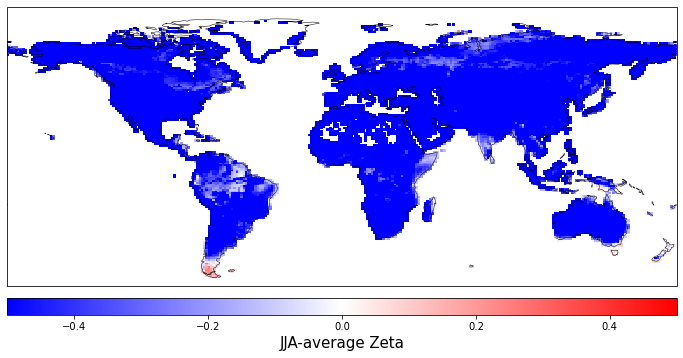

In [46]:
# -------------------------------
# Compute and plot JJA mean zeta
# -------------------------------
iJJA_zeta    = np.where((dates_zeta.month>=6) & (dates_zeta.month<=8))[0]
zeta_JJA     = zetaDS.ZETA.values[iJJA_zeta,:,:]
meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))

# Make map 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# contour_plot = ax1.pcolormesh(zetaDS.lon.values,zetaDS.lat.values,meanZeta_JJA,
#                              cmap='gnuplot',
#                              vmin=-4,vmax=0.5)

contour_plot = ax1.pcolormesh(zetaDS.lon.values,zetaDS.lat.values,meanZeta_JJA,
                             cmap='bwr',
                             vmin=-0.5,vmax=0.5)

ax1.coastlines(linewidth=0.5,edgecolor='0.25')

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA-average Zeta',fontsize=15)


<ipython-input-38-b61dd6703baf>:6: RuntimeWarning: Mean of empty slice
  meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))


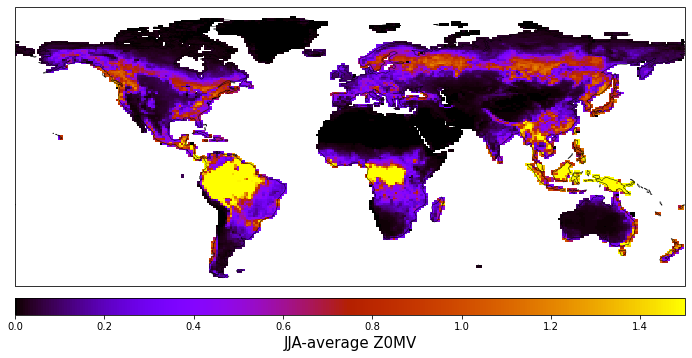

In [38]:
# -------------------------------
# Compute and plot JJA mean Z0MV
# -------------------------------
iJJA_zeta    = np.where((dates_zeta.month>=6) & (dates_zeta.month<=8))[0]
zeta_JJA     = zetaDS.Z0MV.values[iJJA_zeta,:,:]
meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))

# Make map 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

contour_plot = ax1.pcolormesh(zetaDS.lon.values,zetaDS.lat.values,meanZeta_JJA,
                             cmap='gnuplot',
                             vmin=0,vmax=1.5)

ax1.coastlines(linewidth=0.5,edgecolor='0.25')

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA-average Z0MV',fontsize=15)



<ipython-input-44-0ae560665139>:6: RuntimeWarning: Mean of empty slice
  meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))


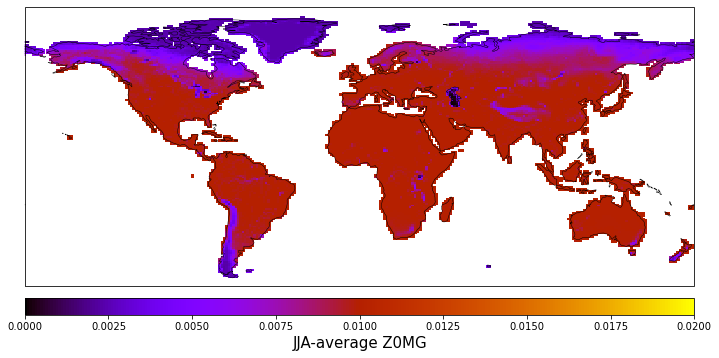

In [44]:
# -------------------------------
# Compute and plot JJA mean Z0MV
# -------------------------------
iJJA_zeta    = np.where((dates_zeta.month>=6) & (dates_zeta.month<=8))[0]
zeta_JJA     = zetaDS.Z0MG.values[iJJA_zeta,:,:]
meanZeta_JJA = np.squeeze(np.nanmean(zeta_JJA, axis=0))

# Make map 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

contour_plot = ax1.pcolormesh(zetaDS.lon.values,zetaDS.lat.values,meanZeta_JJA,
                             cmap='gnuplot',
                             vmin=0,vmax=0.02)

ax1.coastlines(linewidth=0.5,edgecolor='0.25')

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA-average Z0MG',fontsize=15)


